# Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSSv3 import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(500)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

# Source Generation and Mixing Scenario

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.995441278124954


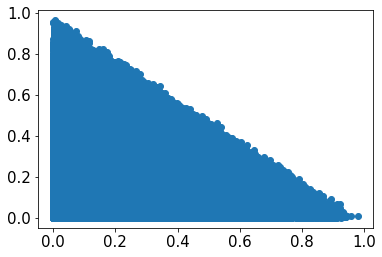

In [2]:
NumberofSources = 5
NumberofMixtures = 10
N = 500000
# https://stackoverflow.com/questions/65154622/sample-uniformly-at-random-from-a-simplex-in-python
S = np.random.exponential(scale=1.0, size=(NumberofSources,int(N)))
S = S / np.sum(S, axis = 0)

SNR=30
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0,:], S[2,:])
plt.show()

# Visualize Generated Sources and Mixtures

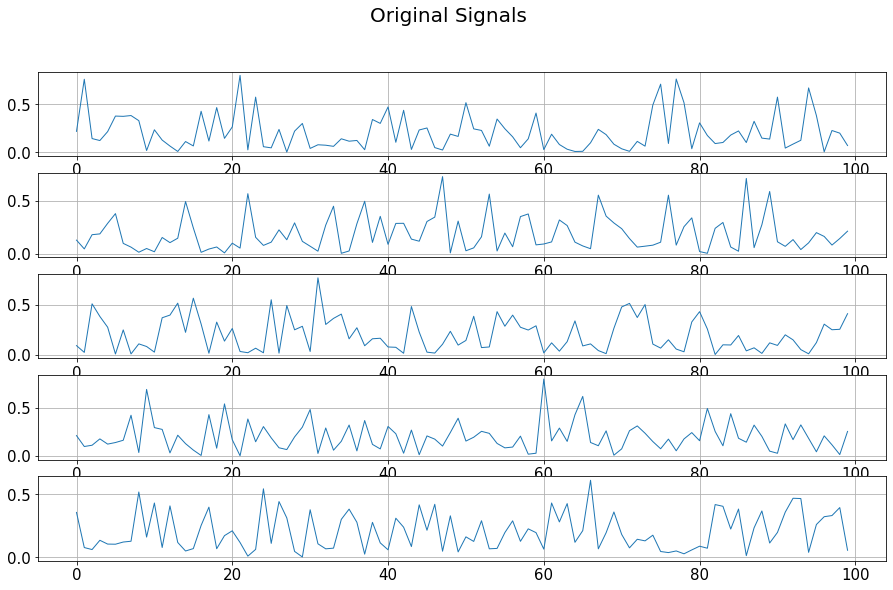

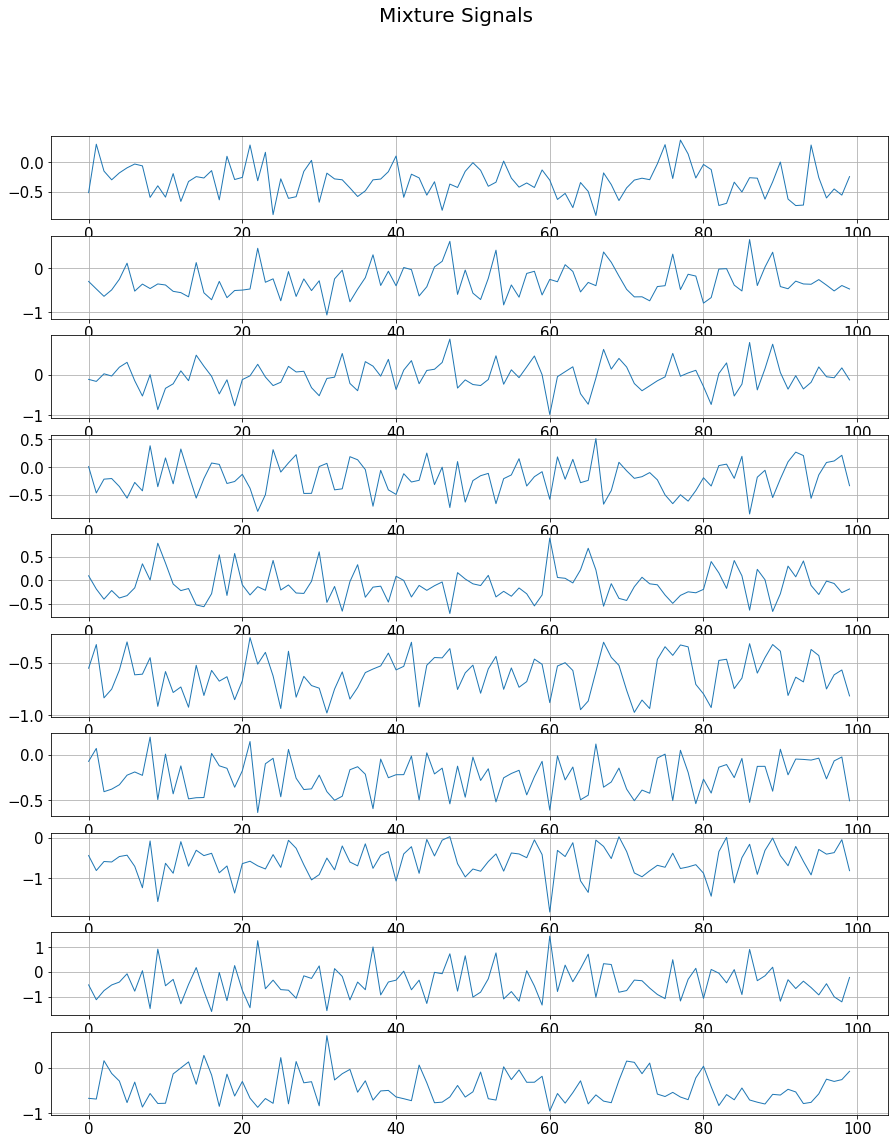

In [3]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
# MUS = 0.25
# OUTPUT_COMP_TOL = 1e-5
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [1,1]
# LayerMinimumGains = [1,1]
# LayerMaximumGains = [1e6,1.001]
# WScalings = [0.0033,0.0033]
# GamScalings = [0.01,0.1]
# zeta = 1e-4
# beta = 0.5
# muD = [20, 1e-2]

# # OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
# synaptic_lr_rule = "divide_by_log_index" 
# # OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
# neural_loop_lr_rule = "divide_by_slow_loop_index"
# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]
# W_HX = np.eye(h_dim, x_dim)
# W_YH = np.eye(s_dim, h_dim)

MUS = 0.25
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [.51,.51]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.01,0.01]
zeta = 1e-4
beta = 0.5
muD = [5, 1]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

# Run WSM Algorithm on Mixture Signals

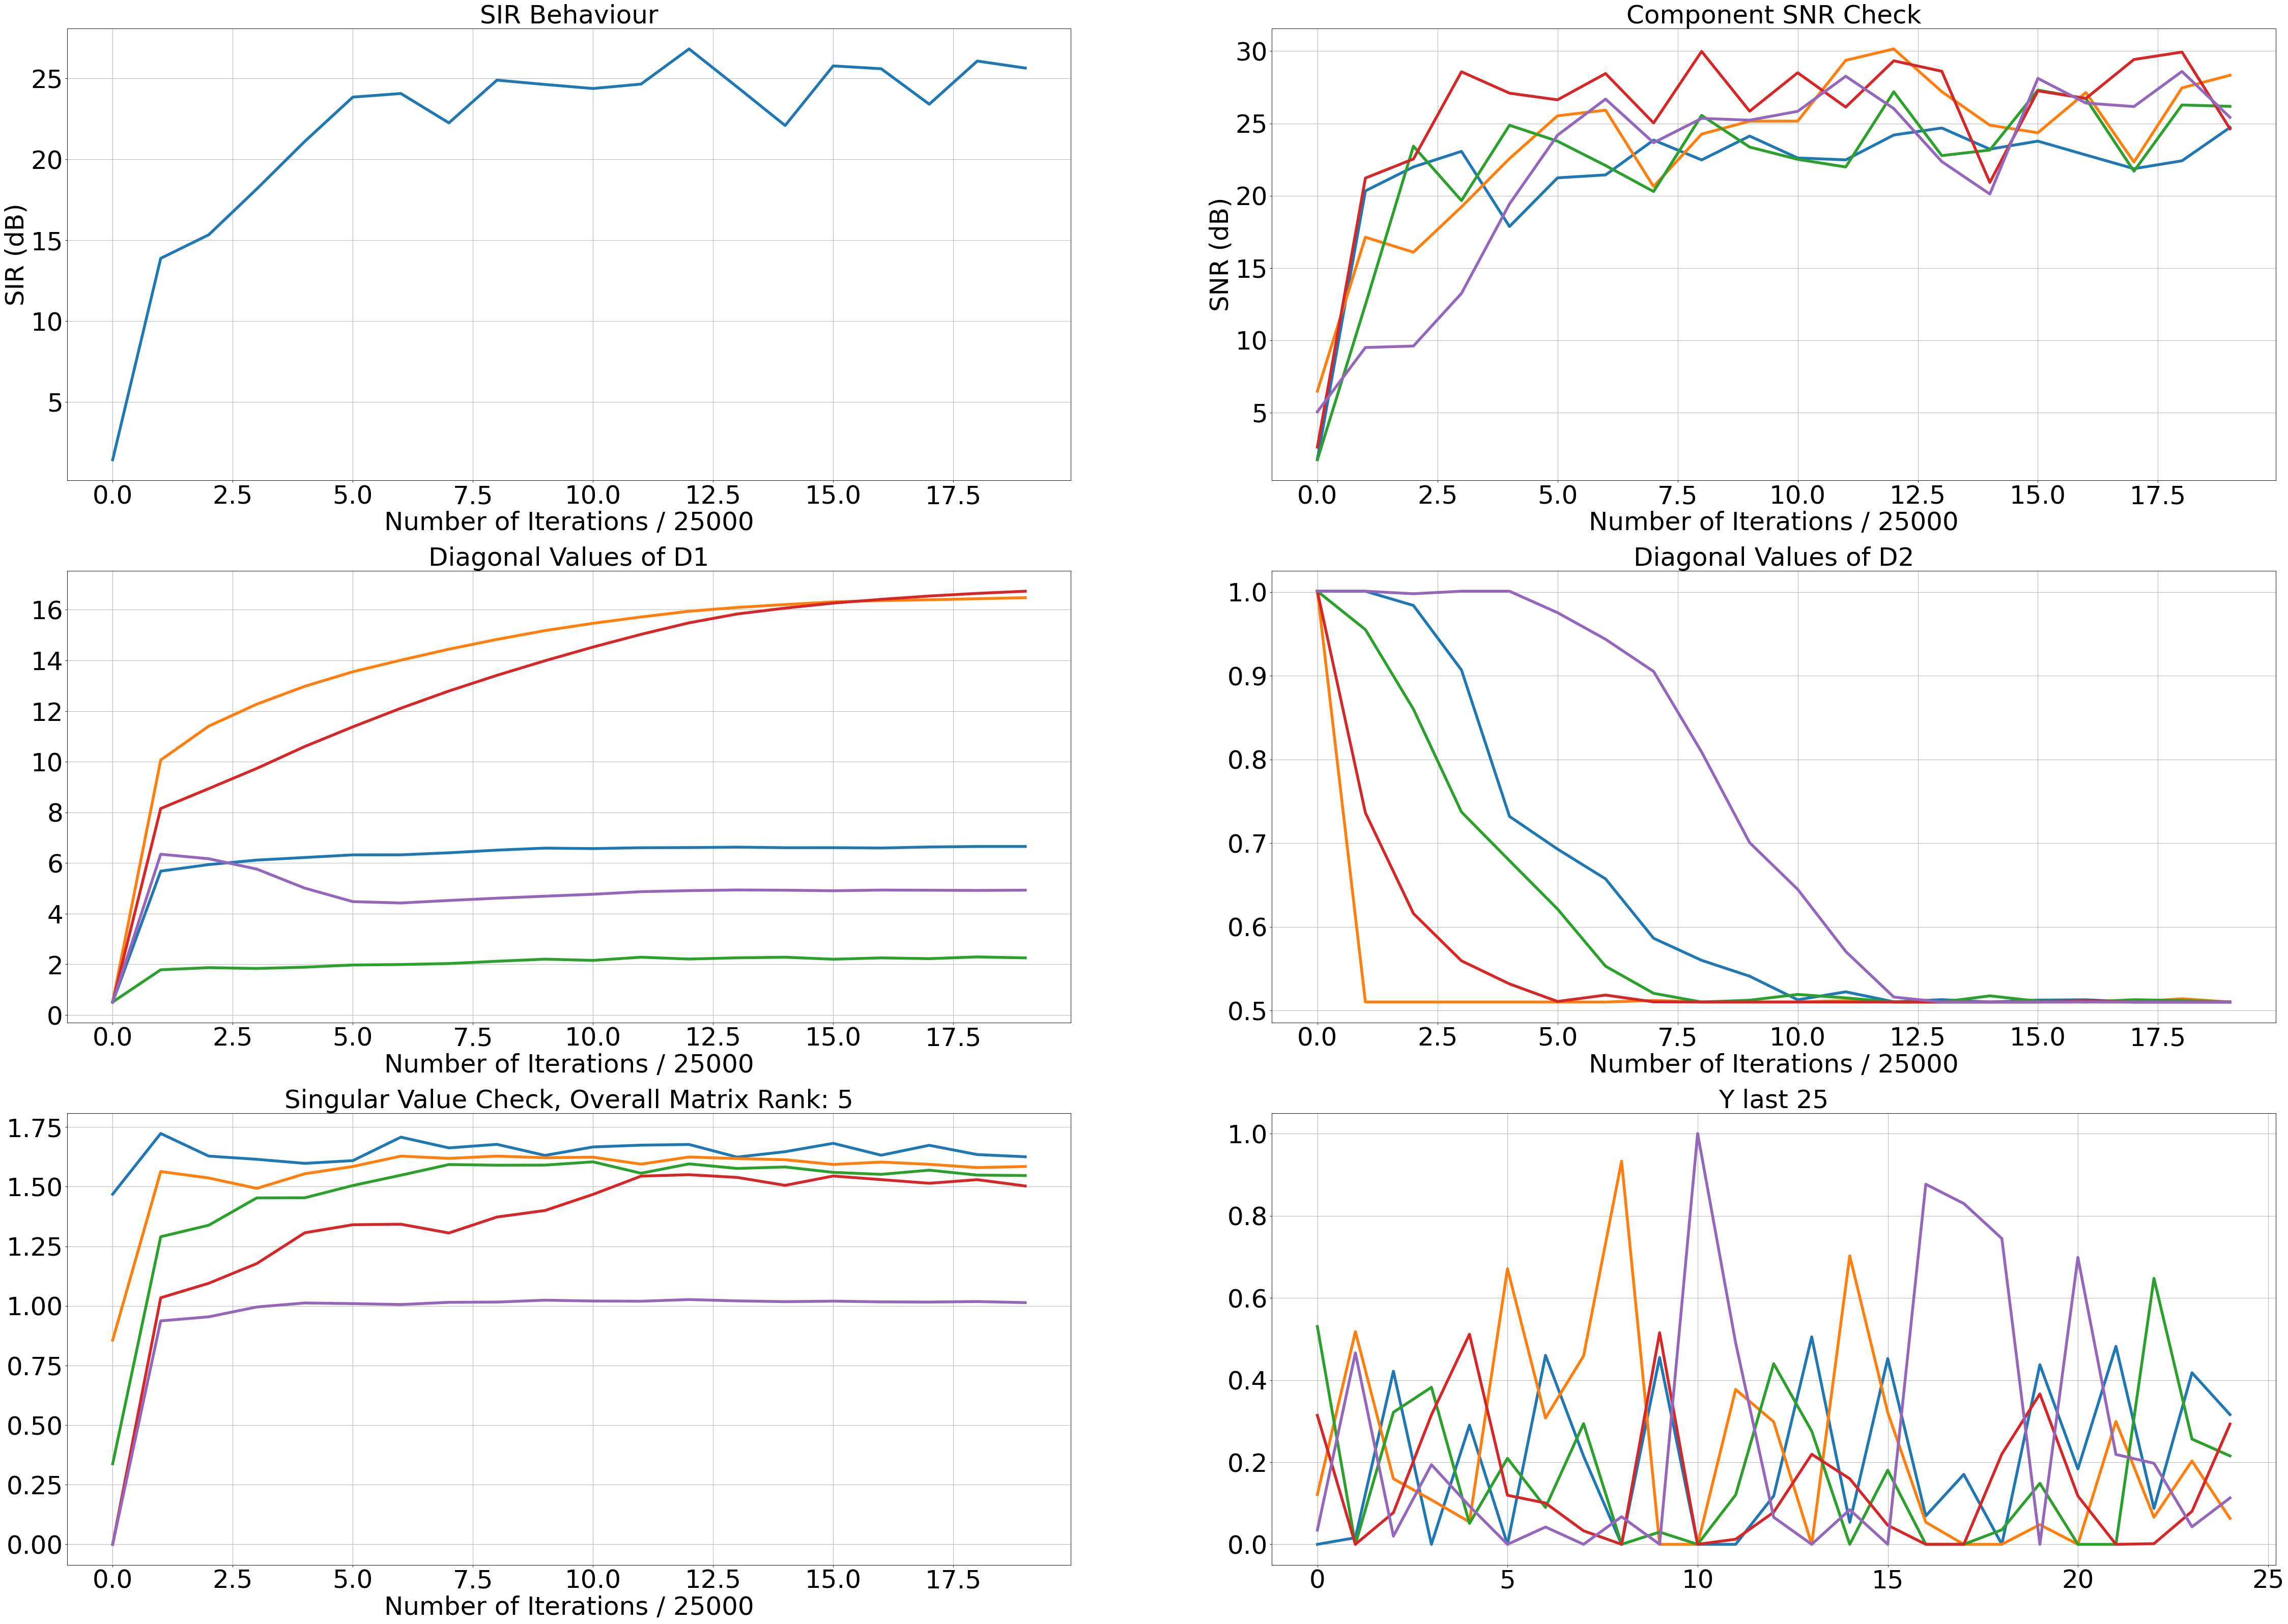

100%|██████████| 500000/500000 [06:54<00:00, 1207.72it/s]


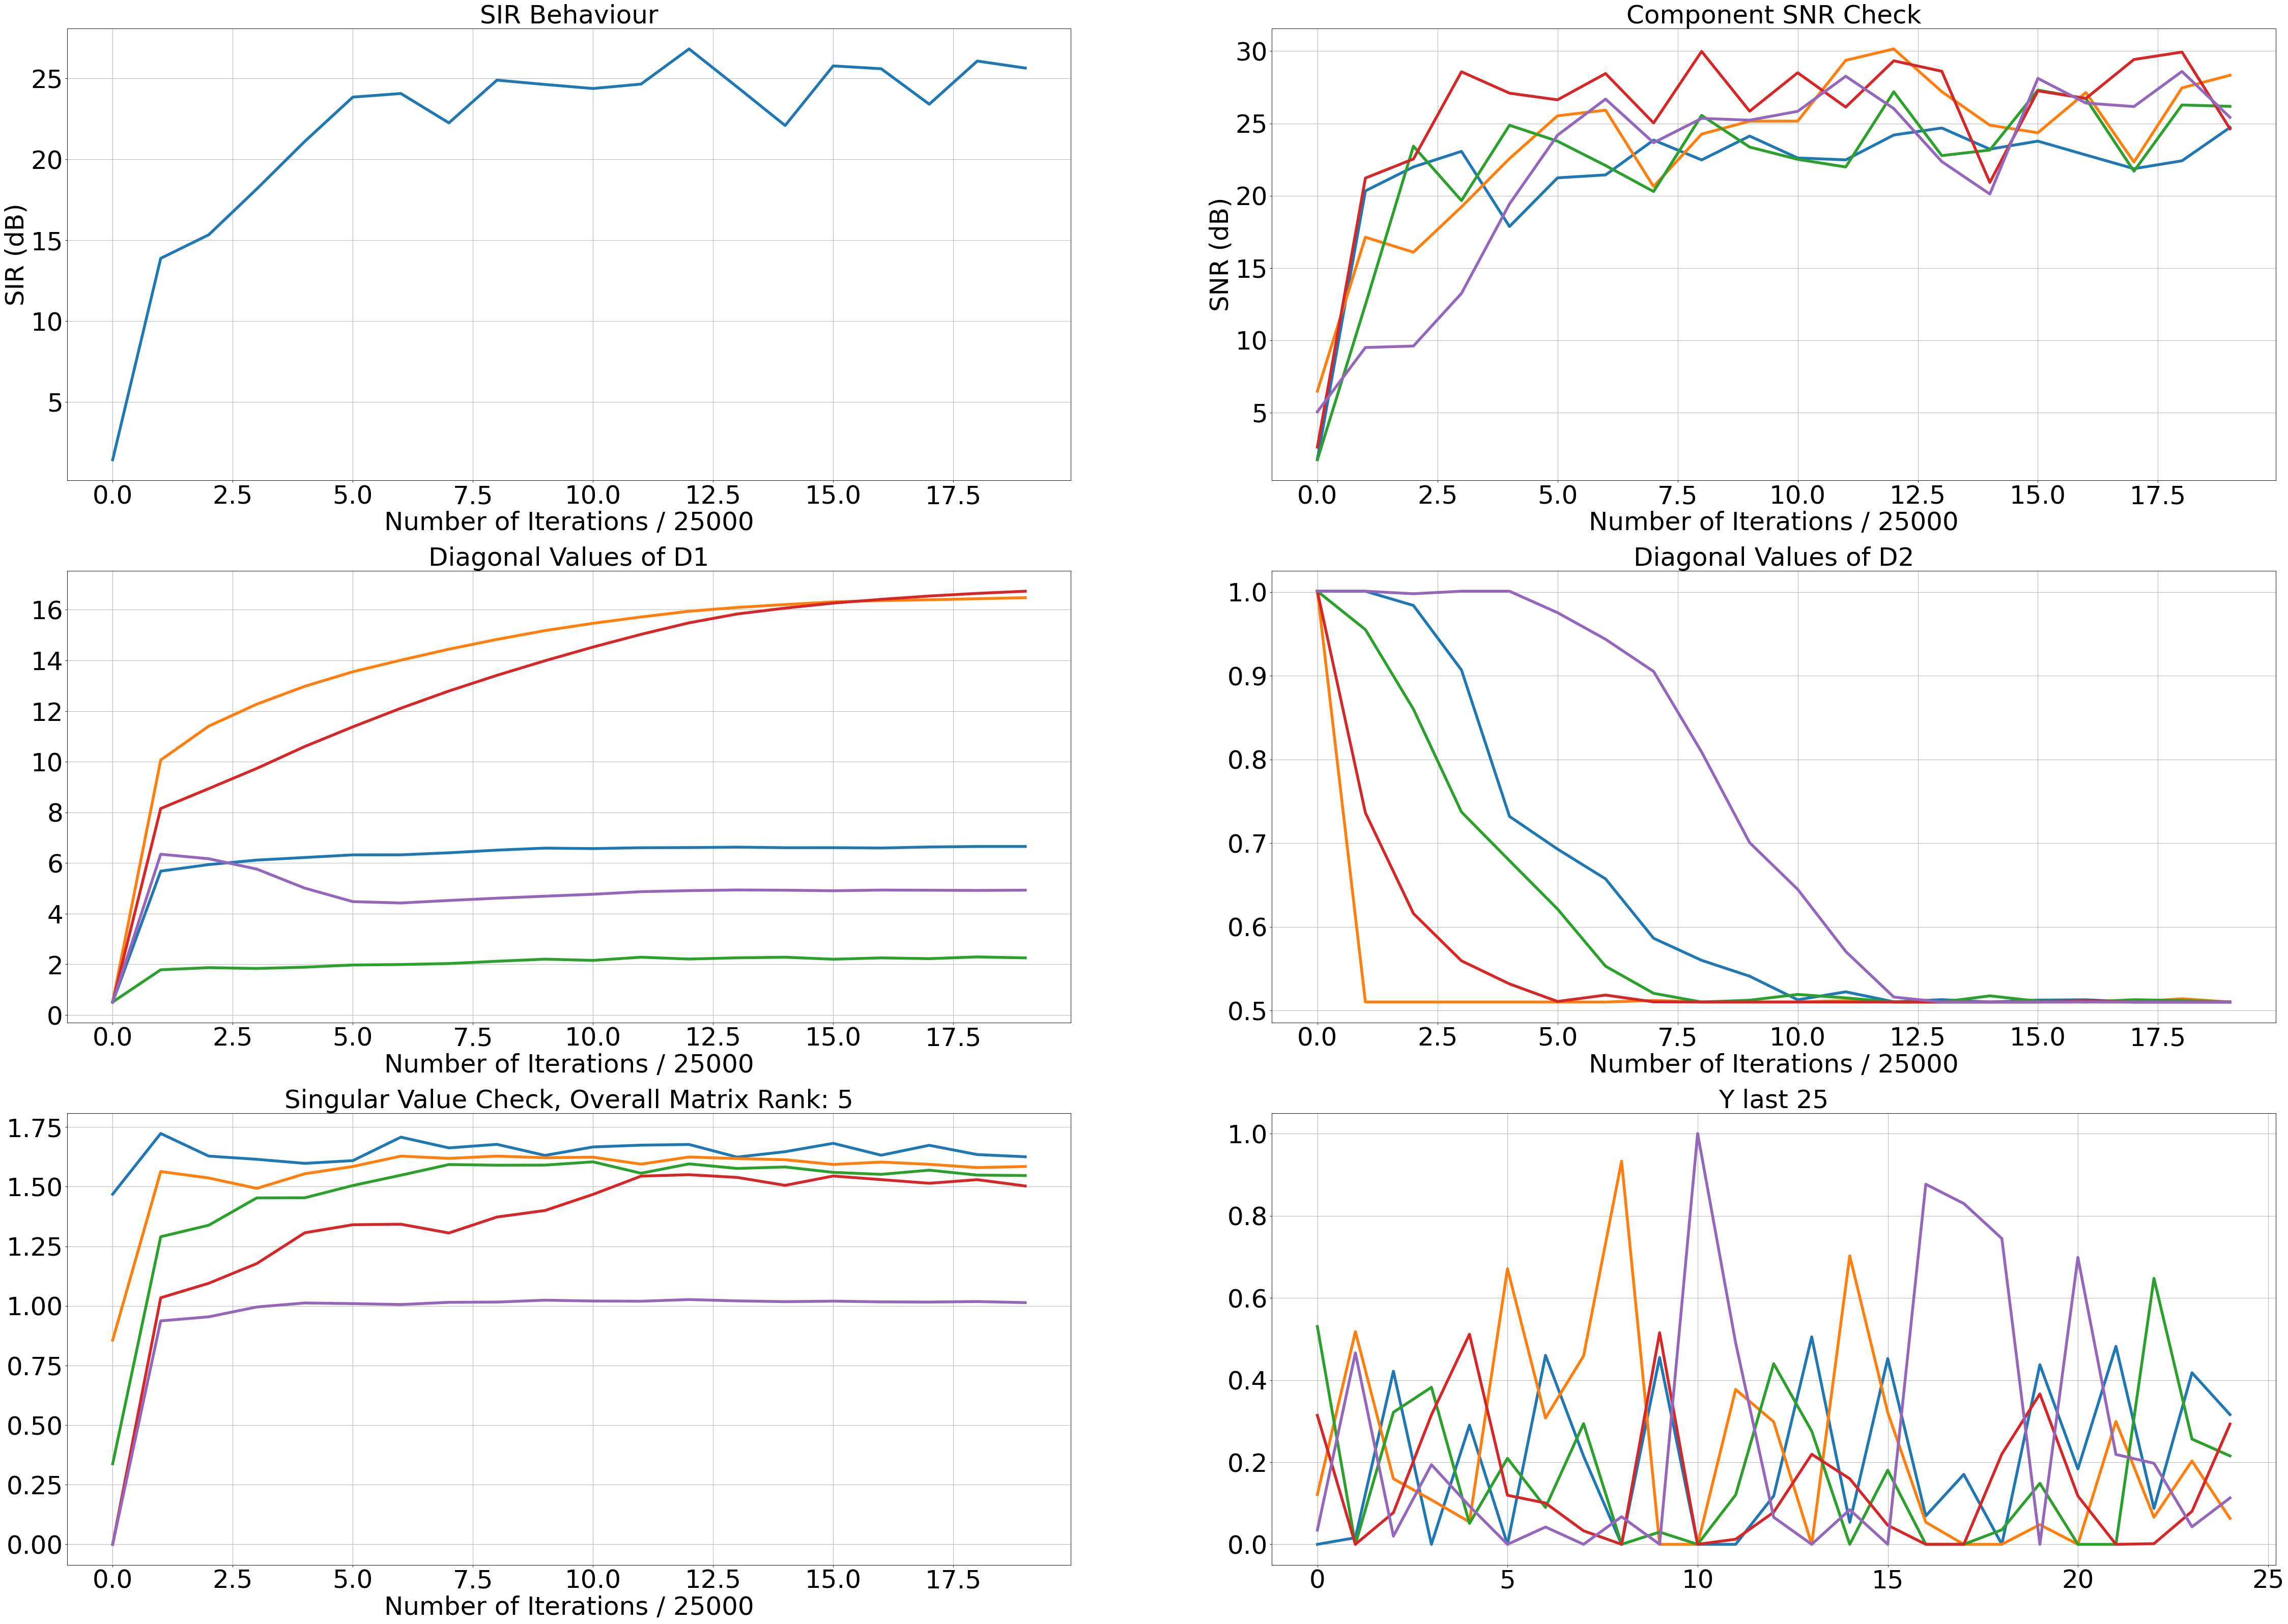

In [5]:
# debug_iteration_point = 10000

# model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
#                      gamma_start = MUS, beta = beta, zeta = zeta, 
#                      muD = muD,WScalings = WScalings,
#                      W_HX = W_HX, W_YH = W_YH,
#                      DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
#                      LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
#                      set_ground_truth = True, S = S, A = A)

# model.fit_batch_simplex(X, n_epochs = 1, neural_lr_start = 0.9, neural_lr_stop = 0.05,
#                         shuffle = False, synaptic_lr_rule = synaptic_lr_rule,
#                         neural_loop_lr_rule = neural_loop_lr_rule,
#                         hidden_layer_gain = 2, debug_iteration_point = debug_iteration_point, 
#                         plot_in_jupyter = True)

debug_iteration_point = 25000

model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gamma_start = MUS, beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings,
                     W_HX = W_HX, W_YH = W_YH,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

model.fit_batch_simplex(X, n_epochs = 1, 
                        neural_lr_start = 0.5, shuffle = False,
                        debug_iteration_point = debug_iteration_point, 
                        plot_in_jupyter = True)

# Visualize SNR Convergence of Each Source Component

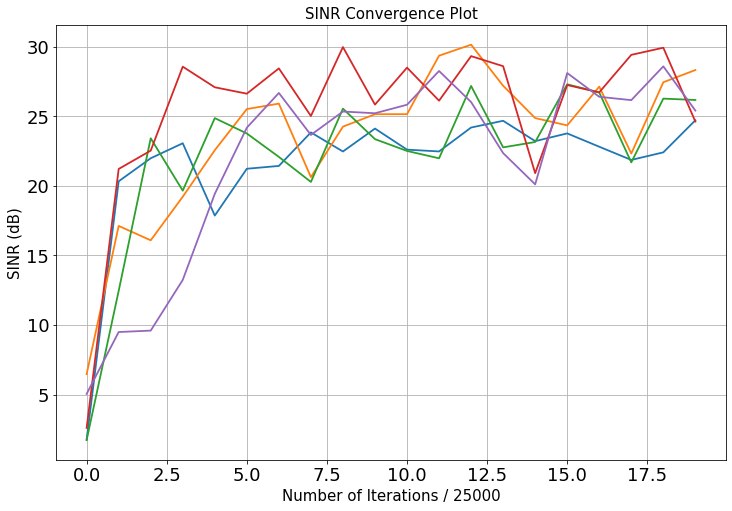

In [6]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [7]:
Szeromean = S - S.mean(axis = 1).reshape(-1,1)
Wf = model.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis = 1).reshape(-1,1)
Y_ = model.signed_and_permutation_corrected_sources(Szeromean,Yzeromean)
coef_ = ((Y_ * Szeromean).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(Szeromean, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, S, False)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [22.85831923 27.8414287  21.99066696 25.70570827 25.71974847]

Overall SINR : 24.306029200232082


In [8]:
# Szeromean = S - S.mean(axis = 1).reshape(-1,1)
# Wf = model.compute_overall_mapping(return_mapping = True)
# Y = Wf @ X
# Yzeromean = Y - Y.mean(axis = 1).reshape(-1,1)
# Y_ = signed_and_permutation_corrected_sources(Szeromean.T,Yzeromean.T)
# coef_ = (Y_ * Szeromean.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
# Y_ = coef_ * Y_
# print("Component SNR Values : {}\n".format(snr(Szeromean.T, Y_)))

# SINRwsm = 10*np.log10(CalculateSINR(Y_.T , Szeromean, False)[0])

# print("Overall SINR : {}".format(SINRwsm))

In [9]:
CalculateSIR(A, Wf)

(15.861106213144986, 5)

In [10]:
display_matrix(Wf@ A)

<IPython.core.display.Math object>

# Vizualize Extracted Signals Compared to Original Sources

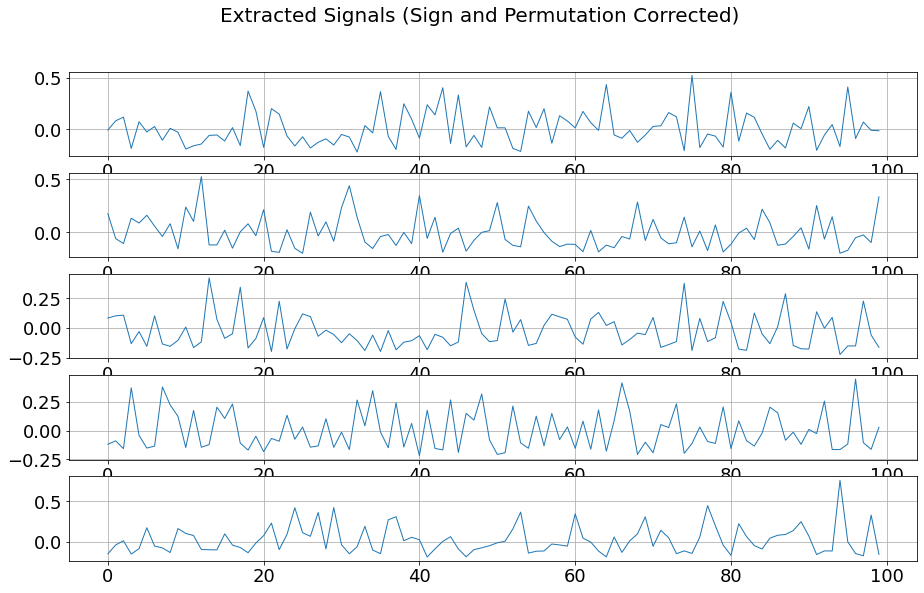

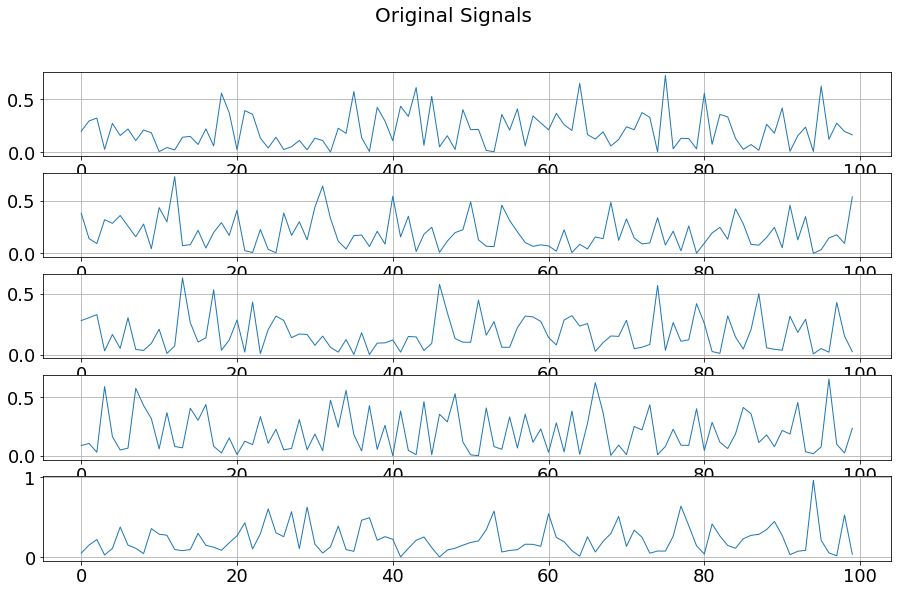

In [11]:
k = 2500
subplot_1D_signals(Y_.T[k:k+100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S.T[k:k+100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

In [12]:
import mir_eval

In [13]:
S.shape, Y_.T.shape

((5, 500000), (500000, 5))

In [14]:
mir_eval.separation.bss_eval_sources(S, Y_.T,
                     compute_permutation=True)

ValueError: The shape of estimated sources and the true sources should match.  reference_sources.shape = (5, 500000), estimated_sources.shape = (500000, 5)